<a href="https://colab.research.google.com/github/AnniaBenitez/Cores_MOD3_AML/blob/main/CORE11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Importar librerías
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from prophet import Prophet

In [15]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
submission_df = pd.read_csv("submit.csv")

In [16]:
print("Primeras filas del conjunto de entrenamiento:")
train_df.head()

Primeras filas del conjunto de entrenamiento:


,No,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,AQI
0,1,-16,-4.0,1020.0,SE,1.79,0,0,129
1,2,-15,-4.0,1020.0,SE,2.68,0,0,148
2,3,-11,-5.0,1021.0,SE,3.57,0,0,159
3,4,-7,-5.0,1022.0,SE,5.36,1,0,181
4,5,-7,-5.0,1022.0,SE,6.25,2,0,138


In [17]:
# Verificar la estructura del dataset
print("\nInformación del conjunto de entrenamiento:")
print(train_df.info())


Información del conjunto de entrenamiento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41757 entries, 0 to 41756
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      41757 non-null  int64  
 1   DEWP    41757 non-null  int64  
 2   TEMP    41757 non-null  float64
 3   PRES    41757 non-null  float64
 4   cbwd    41757 non-null  object 
 5   Iws     41757 non-null  float64
 6   Is      41757 non-null  int64  
 7   Ir      41757 non-null  int64  
 8   AQI     41757 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 2.9+ MB
None


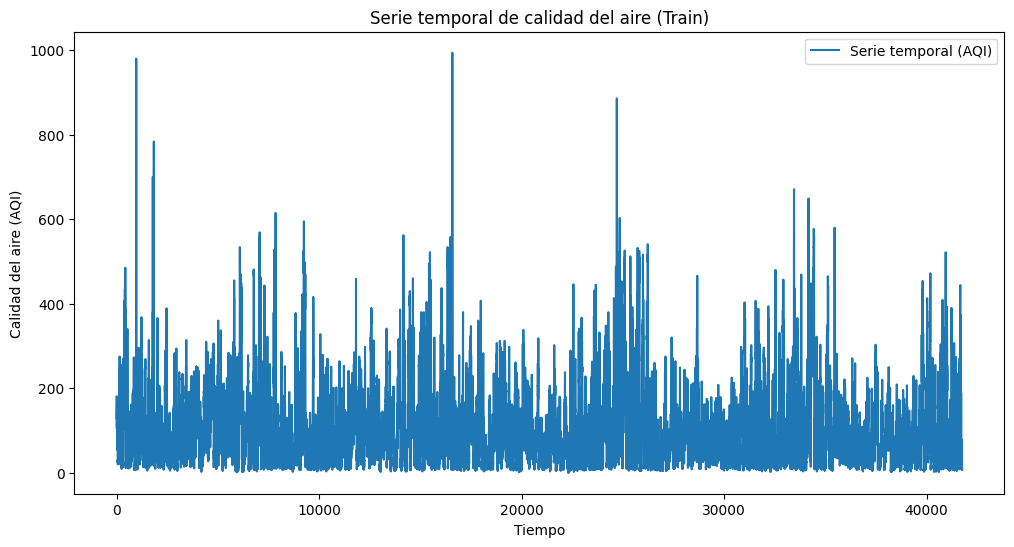

In [18]:
# Seleccionar columnas relevantes
# Supongamos que 'No' es la columna de tiempo y 'AQI' la variable objetivo
train_df = train_df[["No", "AQI"]]
test_df = test_df[["No", "AQI"]]

# Visualizar la serie temporal de entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(train_df["No"], train_df["AQI"], label="Serie temporal (AQI)")
plt.xlabel("Tiempo")
plt.ylabel("Calidad del aire (AQI)")
plt.title("Serie temporal de calidad del aire (Train)")
plt.legend()
plt.show()

In [19]:
# Escalar los datos
scaler = MinMaxScaler()
train_df["AQI_scaled"] = scaler.fit_transform(train_df[["AQI"]])
test_df["AQI_scaled"] = scaler.transform(test_df[["AQI"]])

# Crear ventanas de tiempo
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 24  # Usar 24 horas anteriores
X_train, y_train = create_sequences(train_df["AQI_scaled"].values, seq_length)
X_test, y_test = create_sequences(test_df["AQI_scaled"].values, seq_length)

In [ ]:
# Ajustar las dimensiones para LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Construir el modelo LSTM
model = Sequential([
    LSTM(50, activation="relu", input_shape=(seq_length, 1)),
    Dense(1)
])

# Compilar el modelo
model.compile(optimizer="adam", loss="mse")

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Visualizar la pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.legend()
plt.title("Curvas de pérdida - LSTM")
plt.show()

# Predicciones con LSTM
y_pred_lstm = model.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Métricas para LSTM
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test_inv, y_pred_lstm)
print(f"LSTM - RMSE: {rmse_lstm:.2f}, MAE: {mae_lstm:.2f}")


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.0023 - val_loss: 5.7007e-04
Epoch 2/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 6.8704e-04 - val_loss: 5.6612e-04
Epoch 3/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 6.1582e-04 - val_loss: 4.7024e-04
Epoch 4/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 5.8080e-04 - val_loss: 4.7554e-04
Epoch 5/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 5.7225e-04 - val_loss: 4.5824e-04
Epoch 6/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 5.5323e-04 - val_loss: 4.5212e-04
Epoch 7/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 5.9378e-04 - val_loss: 4.5786e-04
Epoch 8/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 5.9572e-04 - val_loss: 4.5395e-04
Epoch 9/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 5.5723e-04 - val_loss: 4.4916e-04
Epoch 10/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 5.8702e-04 - val_loss: 4.5186e-04
Epoch 11/20
1044/1044 ━━━━━━━━━━━━

In [ ]:
# Preparar datos para Prophet
prophet_train = train_df[["No", "AQI"]]
prophet_train.columns = ["ds", "y"]

# Instanciar y entrenar Prophet
model_prophet = Prophet()
model_prophet.fit(prophet_train)

# Crear predicciones con Prophet
future = model_prophet.make_future_dataframe(periods=len(test_df), freq="H")  # Cambiar 'freq' según el dataset
forecast = model_prophet.predict(future)

# Extraer predicciones de Prophet
y_pred_prophet = forecast["yhat"].values[-len(test_df):]

# Métricas para Prophet
rmse_prophet = np.sqrt(mean_squared_error(test_df["AQI"].values, y_pred_prophet))
mae_prophet = mean_absolute_error(test_df["AQI"].values, y_pred_prophet)
print(f"Prophet - RMSE: {rmse_prophet:.2f}, MAE: {mae_prophet:.2f}")

In [ ]:
# Visualización comparativa
plt.figure(figsize=(12, 6))
plt.plot(test_df["No"][-len(y_test):], y_test_inv, label="Real")
plt.plot(test_df["No"][-len(y_pred_lstm):], y_pred_lstm, label="LSTM", alpha=0.7)
plt.plot(test_df["No"][-len(y_pred_prophet):], y_pred_prophet, label="Prophet", alpha=0.7)
plt.legend()
plt.title("Comparación de predicciones")
plt.show()

# Crear archivo de predicción para enviar
submission_df["AQI"] = y_pred_lstm  # Cambiar a Prophet o combinar ambos si lo deseas
submission_df.to_csv("submission.csv", index=False)
print("Archivo de predicción creado: submission.csv")